In [2]:
from importlib import reload
import json
import pretty_midi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import modules.midiMethods as midiMethods
reload(midiMethods)
from modules.midiMethods import *

import modules.dataMethods as dataMethods
reload(dataMethods)
from modules.dataMethods import *

import modules.models as models
reload(models)

import modules.mlClasses as mlClasses
reload(mlClasses)

<module 'modules.mlClasses' from '/home/ubuntu/storage/380-music-representation/modules/mlClasses.py'>

In [7]:
# if needed, read in filenames... specify if validation or test
data_path = 'training_data/MaestroV2.00/maestro-v2.0.0/'
maestro = pd.read_csv('training_data/maestro-v2.0.0withPeriod.csv', index_col=0)
filenames = list(maestro[maestro['split'] == 'validation']['midi_filename'])

In [4]:
# load data
with open('training_data/oore_v1/oore_train.json', 'r') as f:
    X_train = json.load(f)
    
with open('training_data/oore_v1/oore_val.json', 'r') as f:
    X_val = json.load(f)

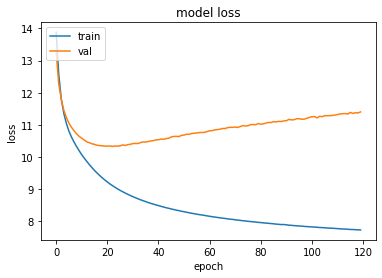

In [4]:
import ast
with open(f'models/nbmodel3/history120eStr.json', 'r') as f:
    hist = ast.literal_eval(json.load(f))
metric = 'loss'
# print(hist)
plt.plot(hist[metric])
plt.plot(hist['val_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pm = 
metric = 'loss'
# print(hist)
plt.plot(hist['val_dense_1_' + metric])
plt.plot(hist['val_dense_2_' + metric])
plt.plot(hist['val_dense_3_' + metric])
plt.plot(hist['val_dense_4_' + metric])
plt.plot(hist['val_dense_5_' + metric])
plt.plot(hist['val_dense_' + metric])
plt.plot(hist['val_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
# Graphing note lengths
durations = []
lengths = []
for i in range(len(filenames)):
    print(f'file {i} of {len(filenames)}')
    pm = pretty_midi.PrettyMIDI(data_path + filenames[i])
    sustain_only(pm)
    desus(pm)
    last_note_start = 0
    for note in pm.instruments[0].notes:
        lengths.append(note.end - note.start)
    

file 0 of 137
file 1 of 137
file 2 of 137
file 3 of 137
file 4 of 137
file 5 of 137
file 6 of 137
file 7 of 137
file 8 of 137
file 9 of 137
file 10 of 137
file 11 of 137
file 12 of 137
file 13 of 137
file 14 of 137
file 15 of 137
file 16 of 137
file 17 of 137
file 18 of 137
file 19 of 137
file 20 of 137
file 21 of 137
file 22 of 137
file 23 of 137
file 24 of 137
file 25 of 137
file 26 of 137
file 27 of 137
file 28 of 137
file 29 of 137
file 30 of 137
file 31 of 137
file 32 of 137
file 33 of 137
file 34 of 137
file 35 of 137
file 36 of 137
file 37 of 137
file 38 of 137
file 39 of 137
file 40 of 137
file 41 of 137
file 42 of 137
file 43 of 137
file 44 of 137
file 45 of 137
file 46 of 137
file 47 of 137
file 48 of 137
file 49 of 137
file 50 of 137
file 51 of 137
file 52 of 137
file 53 of 137
file 54 of 137
file 55 of 137
file 56 of 137
file 57 of 137
file 58 of 137
file 59 of 137
file 60 of 137
file 61 of 137
file 62 of 137
file 63 of 137
file 64 of 137
file 65 of 137
file 66 of 137
file 

639425

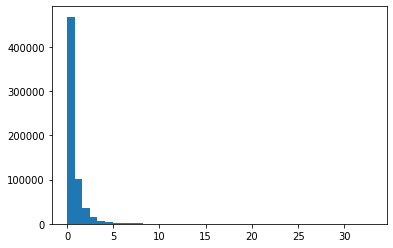

In [17]:
plt.hist(lengths, bins=40)
len(lengths)